# Toward Prediction
This document includes the steps used for Dulux to arrive to a prediction of opportunities. Warning the data set used has been an aggregation, which at the moment is more black art than anything else, in a way that manual steps are nessary and therefor error prone.

The steps taken in this document are:
1. Transform the categories for type and project status variable
2. Split the data set in sub-saample based on Hot and Warm
3. For each sub sample buuld the hot encoding and conditional porbabilities
3. For ecah sub sample build the classification using logitc regression
4. Metrics by cnfusion matrix.


In [13]:
# What we use
import pandas as pd
import numpy  as np
from sklearn.linear_model import LogisticRegression # No Glm in Python .... 
from sklearn.metrics  import roc_curve, auc 
from sklearn.metrics  import confusion_matrix
from sklearn.metrics  import ConfusionMatrixDisplay
from re import search
import vtreat
# For display
import matplotlib.pyplot as plt
# We read our data they have been prepared
all_data = pd.read_csv("../data/data_set.csv")


# The data set 
The transformation of the two variables. See below a snapshot, only few variables are used in the model, for details about the data set report to other reports.

For pandas we have no defined index.

In [2]:
all_data.head()

,Unnamed: 0,projectid,name,company,qualification_level_code_text,user_status_code_text,account_life_cycle_status_code_text,priority_code_text,group_code_text,account_state,...,projectstage,project_status,remarks,origin_type_code_text,life_cycle_status_code_text,value,opportunity,creation_date,beg_date,log_value
0,1,185794017,Hill St Richmond NZ 7020,Newton Survey - Richmond,Warm,Qualified,Active,Normal,Commercial Project,NZ,...,Documentation,Development Application,{!*20 lot residential subdivision*Associated w...,BCI/Cordell,Qualified,1000000,0,2021-03-31 16:52:06,2021-03-01,13.815511
1,2,84980017,248-250 Normanby Rd South Melbourne VIC 3205,Planning & Property Partners Pty Lt,Hot,Qualified,Active,Normal,Commercial Project,VIC,...,Documentation,Appeal Lodged,{!*Demolish existing commercial buildings*240 ...,BCI/Cordell,Qualified,60000000,0,2021-04-12 04:30:18,2021-04-01,17.909855
2,3,187295017,SH4 PARAPARA RD SLIP REPAIR,New Zealand Transport Agency (NZTA),Warm,Qualified,Active,Normal,Commercial Project,NZ,...,Documentation,Tenders To Be Called,{!*Slip repair*Roadworks!*Reinsate road*Earthw...,BCI/Cordell,Qualified,5000000,0,2019-11-01 15:13:07,2019-11-01,15.424948
3,4,224860017,17 Carnforth St Green Island NZ 9018,Calder Stewart Industries Ltd - Mil,Warm,Qualified,Active,Normal,Commercial Project,NZ,...,Construction,Construction Commenced,{!*Alterations & additions of existing office*...,BCI/Cordell,Qualified,2100000,0,2020-12-22 03:30:32,2020-12-01,14.557448
4,5,214518017,OPHIR PEACE MEMORIAL HALL,Central Otago District Council,Warm,Qualified,Active,Normal,Commercial Project,NZ,...,Tender,Contract Awarded/Builder Apptd,{!*Alterations & additions to existing communi...,BCI/Cordell,Qualified,210000,0,2021-03-19 16:19:37,2021-03-01,12.254863


We reduce the categories for project type and named it type

In [3]:
# First project type for analysis report to first report
all_data['project_type'] = all_data['project_type'].str.lower()
#  We do the mapping !!!
all_data['type'] = np.where( all_data['project_type'].str.findall('apartments'), 'apartment', 'no')
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall('chalet|house')  , 'townhouse', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall("commercial|motel|hotel|showroom|industrial|supermarket|factory")  , 'commercial', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall("office")  , 'commercial', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall("road")  , 'road', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall("streetscap|intersection")  , 'road', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall("aged care|retirement")  , 'aged care', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall( "retirement village|senior living villa|senior living unit")  , 'aged care', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall('cycle')  , 'road', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall('hotel|restaurant')  , 'hospitality', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') &  all_data['project_type'].str.findall('prison|school|classroom|community centre|social housing|bridge|childcare centre|hospital|medical|water infrastructure|childcare centre|airport')  , 'public', all_data['type'])
all_data['type'] = np.where( (all_data['type'] =='no') , 'other', all_data['type'])


We do the same with project status the category big_effect is based on the first analysis of impact

In [4]:
all_data['project_status'] = np.where(all_data['project_status'].str.findall('Rezoning|Tenders To Be Called|Site Works Commenced|Construction Certificate Approved|Development Approval|Tenders Called'), 'big_effect', all_data['project_status'])

The distribution of the type after transformation is the following:

In [5]:
print(all_data.type.value_counts())

other          1756
townhouse       969
apartment       924
public          669
commercial      470
road            361
aged care       143
hospitality      50
Name: type, dtype: int64


Similar view for project_status 

In [6]:
print(all_data.project_status.value_counts())

big_effect                                                 2021
Development Application                                     498
Tenderers Named                                             460
Construction Commenced                                      400
Tenders Closed Contract not yet Let                         387
Feasibility/EIS/Submission of Proposals/Master Planning     324
Deferred                                                    298
Construction Certificate Submitted                          240
Contract Awarded/Builder Apptd                              223
Appeal Lodged                                                95
Abandoned                                                    92
Site for Sale                                                74
Sketch plans                                                 72
Expressions / Registrations of Interest                      70
Competition / Design Tender                                  60
Winner Announced / Contract Awarded     

## The split of data set
As mentioned the qualification_level_code_text is defined by Warn or Hot, we do a natural log transforation, which still gives us a bimodal distribution, due to the fact of transparency linear model is of choice and therefor the distribution of this variable is not reall suitable.
The other point and as mentioned in EDA, there is clear dihhereces between both, first this is judgement and then the project are different. 

In [7]:
# We do a log transformed and then split in warm and hot 
# The varaiables used have been selected based on the analysis of the effect
all_data['log_value']  = np.log(all_data['value'])
variable_name =['opportunity','type','log_value', 'account_state', 'project_status', 'projectstage', 'consistency_status_code_text', 'life_cycle_status_code_text']
# Split 
warm_data  = all_data[ all_data['qualification_level_code_text'] =='Warm']
hot_data   = all_data[ all_data['qualification_level_code_text'] =='Hot' ]
#  Reduce 
col_pos =[]
for ref in variable_name:
        col_pos.append(all_data.columns.get_loc(ref))
        
warm_data  = warm_data.iloc[:,col_pos]    
hot_data   = hot_data.iloc[:,col_pos]        

## The warm mode
In the step of this section is as follow:
1. Build the transformed data set and rmove the proportions
2. Build the ligitics regression 
3. Metrics

In [8]:
# In python we have to extract the response 
opportunity      = np.asarray(warm_data['opportunity'])
warm_independent = warm_data.drop(['opportunity'],axis=1)

Build the transformation for Warm data set, we have to remove the prevalence. 

In [9]:
plan       = vtreat.BinomialOutcomeTreatment(outcome_target=True)
warm_trans = plan.fit_transform(warm_independent, opportunity)
# Just to check we have all advised we still remove prevalence
model_vars = np.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
warm_trans =warm_trans.drop(['account_state_prevalence_code','life_cycle_status_code_text_prevalence_code','projectstage_prevalence_code','type_prevalence_code' ], axis=1)

Build the logitic regression, we have the warm data set, the transformation could be improved, we use the binomial already. 
In Python we have to increase the number of iteration, it appears that the MLE is different from other environment such as SAS or R. 

In [10]:
warm_model=LogisticRegression(max_iter= 200) 
warm_model.fit( warm_trans   ,opportunity )
warm_predict = warm_model.predict( warm_trans)

The confusion matrix for Warm is as expected and good as shown below:

In [11]:
cnf_matrix = confusion_matrix(opportunity, warm_predict)
print(cnf_matrix)


[[4283   30]
 [   1  115]]


The prediction distribution is the following, we can notice the perfect separation, which explain the cut-of of .5.

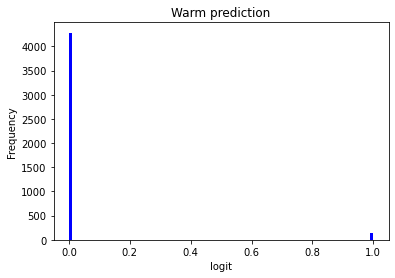

In [20]:
dsp_tmp =plt.hist( warm_predict, bins=100, facecolor='blue', linewidth =1)
x_note= plt.xlabel('logit')
y_note= plt.ylabel('Frequency')
tiitle_note =plt.title('Warm prediction')

For Warm we could sustain that the model even if simple could deliver good reults.
## The hot model
The hot model is strutured as the warm model, the difference will in the significance of the variables. In this case we have more false positive than with the maximum likelihood of glm, but the results are evry acceptable.


In [21]:
# The hot model follows the warm model
opportunity_hot = np.asarray(hot_data['opportunity'])
hot_independent = hot_data.drop(['opportunity'],axis=1)
plan_hot        = vtreat.BinomialOutcomeTreatment(outcome_target=True)
hot_trans       = plan_hot.fit_transform(hot_independent, opportunity_hot)
hot_model       =LogisticRegression(max_iter= 200)
hot_model.fit( hot_trans   ,opportunity_hot )
hot_predict = hot_model.predict( hot_trans)
hot_matrix   = confusion_matrix(opportunity_hot, hot_predict)
print(hot_matrix)

[[693  35]
 [  0 185]]


The prediction of the hot subsample, as with warn the badly classified are certainly exception we could not modelise with the current information.

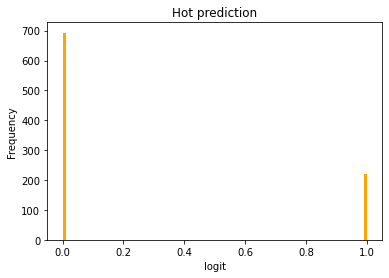

In [23]:
dsp_tmp =plt.hist( hot_predict, bins=100, facecolor='orange', linewidth =1)
x_note= plt.xlabel('logit')
y_note= plt.ylabel('Frequency')
tiitle_note =plt.title('Hot prediction')

# Conclusion
The prediction of opportunity based on the current data set is very possible. Further analysis is certainly necessary and the main message is first fix the dat entries. 
One area, which could be of interest and based on bot Warm and Hot is the badly classify, as showm the model is nearly too perfect with clear separation, therefore we could infer that we have information missing to have better results. 
